# Pull the data from Athena and turn it into training data

Create a series of temperature strings that look like this:

[t0, t1 ... t23]

...with 24 temperatures for a given site.  Create these by sliding a window along unique temperatures by site.

TODO:

* ~More than one site~
* ~Deal with nulls~
* Deal with missing data by selecting against the datetime, not relying on a row being there for the measurement
* ~Better windowing~
* Other data as inputs (pressure, wind speed etc)
* Encode time as input (e.g. hour of day)
* Wind speed and direction as vector (snazzy!)
* Longer input history
* ~More sites in input~
* ~Normalise the data (temp => -1 - 1 etc)~


In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor
from sklearn.model_selection import train_test_split
from numpy.lib.stride_tricks import sliding_window_view

cursor = connect(s3_staging_dir="s3://dantelore.queryresults/pyathena/",
                 region_name="eu-west-1", cursor_class=PandasCursor).cursor()

length = 24
csv_data_cache_filename = "data/weather_models/raw_data.csv"

# Load the data from disk or Athena
if Path(csv_data_cache_filename).is_file():
    print("Loading weather data from cache")
    df = pd.read_csv(csv_data_cache_filename)
else:
    df = cursor.execute("select site_name, observation_ts, temperature from lake.weather order by site_name, observation_ts").as_pandas()
    df.to_csv(csv_data_cache_filename, index=False)

# Replace NaN's with 0 - which will confuse the network a little, but will preserve the time element of the input
df['temperature'] = df['temperature'].fillna(0.0)

# Convert all the numbers to float32 for tensorflow
df['temperature'] = df['temperature'].astype('float32')

# Calculate the offset and scale for normalising the data
train_mean = df['temperature'].mean()
train_std = df['temperature'].std()
print(f"Temperature mean: {train_mean}, stdev: {train_std}")

# Normalise the data
df['temperature'] = df['temperature'].apply(lambda x: (x - train_mean) / train_std)     

input_sequences = np.empty([0, 24])
# Window the data
for site_name, readings in df.groupby('site_name'):
    temps = readings['temperature'].to_numpy()

    windows = sliding_window_view(temps, 24)

    input_sequences = np.append(windows, input_sequences, axis=0)

    print(f"Window shape site {site_name}: {windows.shape}")

print(f"Combined data shape: {input_sequences.shape}")

# Wrap up the individual readings into a single 'timestep' for the RNN.  Add pressure, TOD etc to this bag later if you want
input_sequences = np.array([[[y] for y in x] for x in input_sequences])

print(f"All data shape when wrapped: {input_sequences.shape}")

# Some funky numpy slicing here.  We are slicing by axis in a 3D array - so xs takes all but the last item on the 2nd axis, ys takes only the last
xs = input_sequences[:,:-1]
ys = input_sequences[:,-1]

x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.05)
#x_train = xs[0:8000]
#x_test = xs[8000:]
#y_train = ys[0:8000]
#y_test = ys[8000:]

# ((?, 23, 1), (?, 1), (?, 23, 1), (?, 1))
print(f"x_train: {x_train.shape} y_train: {y_train.shape} x_test: {x_test.shape} y_test: {y_test.shape}")



Loading weather data from cache
Temperature mean: 10.083017349243164, stdev: 5.685093402862549
Window shape site ABERDARON: (8820, 24)
Window shape site ABERDEEN AIRPORT: (9040, 24)
Window shape site ABERPORTH: (9524, 24)
Window shape site ABOYNE: (9464, 24)
Window shape site ALBEMARLE: (9492, 24)
Window shape site ALTNAHARRA SAWS: (9435, 24)
Window shape site ANDREWSFIELD: (9399, 24)
Window shape site AONACH MOR SUMMIT: (5290, 24)
Window shape site AULTBEA: (9519, 24)
Window shape site AVIEMORE: (9434, 24)
Window shape site BALLYPATRICK FOREST: (9526, 24)
Window shape site BALTASOUND: (9455, 24)
Window shape site BEALACH NA BA: (8539, 24)
Window shape site BEDFORD: (9526, 24)
Window shape site BELFAST INTERNATIONAL AIRPORT: (9550, 24)
Window shape site BELMULLET: (9557, 24)
Window shape site BENSON: (9318, 24)
Window shape site BINGLEY SAMOS: (9525, 24)
Window shape site BOSCOMBE DOWN: (9533, 24)
Window shape site BOULMER: (9072, 24)
Window shape site BOURNEMOUTH AIRPORT: (9267, 24)
W

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, InputLayer
from tensorflow.keras.optimizers import Adam

model = Sequential([
    InputLayer((length - 1, 1)),
    LSTM(64),
    Dense(units=8, activation='relu'),
    Dense(units=1, activation='linear')
])

adam = Adam(lr=0.0001)

model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=adam, metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Create the training history dataframe at the same time as the model...
history_df = pd.DataFrame(columns=['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-01-25 14:01:47.981495: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-25 14:01:47.981785: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


/Users/dan/Development/simple-prediction/.venv/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Starting Run 0/1
Epoch 1/10


2023-01-25 14:01:48.606466: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-25 14:01:49.318880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-25 14:01:49.488482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-25 14:01:49.672201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-25 14:09:21.323755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-25 14:09:21.392030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36207/36207 - 486s - loss: 0.0247 - mean_absolute_error: 0.1046 - val_loss: 0.0181 - val_mean_absolute_error: 0.0939 - 486s/epoch - 13ms/step
Epoch 2/10


36207/36207 - 479s - loss: 0.0181 - mean_absolute_error: 0.0937 - val_loss: 0.0179 - val_mean_absolute_error: 0.0927 - 479s/epoch - 13ms/step
Epoch 3/10


36207/36207 - 487s - loss: 0.0178 - mean_absolute_error: 0.0929 - val_loss: 0.0176 - val_mean_absolute_error: 0.0921 - 487s/epoch - 13ms/step
Epoch 4/10


36207/36207 - 497s - loss: 0.0177 - mean_absolute_error: 0.0925 - val_loss: 0.0175 - val_mean_absolute_error: 0.0914 - 497s/epoch - 14ms/step
Epoch 5/10


36207/36207 - 531s - loss: 0.0176 - mean_absolute_error: 0.0921 - val_loss: 0.0175 - val_mean_absolute_error: 0.0914 - 531s/epoch - 15ms/step
Epoch 6/10
36207/36207 - 520s - loss: 0.0175 - mean_absolute_error: 0.0919 - val_loss: 0.0175 - val_mean_absolute_error: 0.0915 - 520s/epoch - 14ms/step
Epoch 7/10


36207/36207 - 519s - loss: 0.0175 - mean_absolute_error: 0.0918 - val_loss: 0.0174 - val_mean_absolute_error: 0.0912 - 519s/epoch - 14ms/step
Epoch 8/10
36207/36207 - 480s - loss: 0.0174 - mean_absolute_error: 0.0916 - val_loss: 0.0174 - val_mean_absolute_error: 0.0910 - 480s/epoch - 13ms/step
Epoch 9/10


36207/36207 - 480s - loss: 0.0174 - mean_absolute_error: 0.0915 - val_loss: 0.0173 - val_mean_absolute_error: 0.0913 - 480s/epoch - 13ms/step
Epoch 10/10
36207/36207 - 500s - loss: 0.0173 - mean_absolute_error: 0.0914 - val_loss: 0.0174 - val_mean_absolute_error: 0.0909 - 500s/epoch - 14ms/step


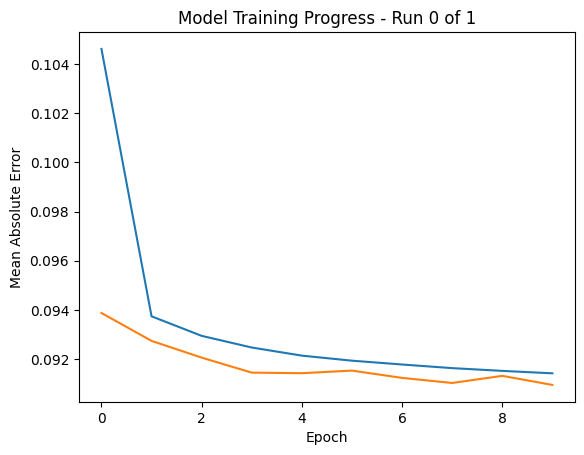

In [3]:
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.callbacks import ModelCheckpoint


tf.get_logger().setLevel('ERROR')

run_count = 1
epochs_per_run = 10
model_filename = 'data/weather_models/model1/'

cp = ModelCheckpoint(model_filename, save_best_only=True, verbose=0)

for run in range(0, run_count):
    print(f"Starting Run {run}/{run_count}")
    # Use verbose=2 here to prevent progreess bars locking up jupyter after a few hours
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs_per_run, verbose=2, callbacks=[cp])

    history_df = pd.concat([history_df, pd.DataFrame(history.history)], ignore_index=True)

    plt.plot(history_df['mean_absolute_error'], label="Training Error")
    plt.plot(history_df['val_mean_absolute_error'], label="Validation Error")
    plt.title(f'Model Training Progress - Run {run} of {run_count}')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.show()

    1/36207 [..............................] - ETA: 3:15:55

2023-01-25 15:24:47.357013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-25 15:24:47.423327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36207/36207 [==============================] - 239s 7ms/step


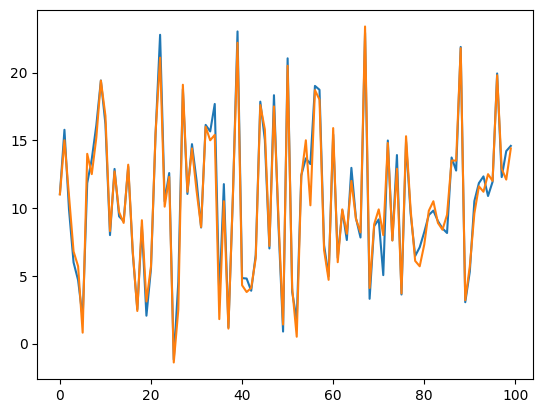

In [4]:
from tensorflow.keras.models import load_model

# model = load_model(model_filename)

train_predictions = model.predict(x_train).flatten()
train_results = pd.DataFrame(data={'Predicted': train_predictions, "Actual": y_train.flatten()})

train_results['Predicted'] = train_results['Predicted'].apply(lambda x: x * train_std + train_mean)
train_results['Actual'] = train_results['Actual'].apply(lambda x: x * train_std + train_mean)

plt.plot(train_results['Predicted'][0:100])
plt.plot(train_results['Actual'][0:100])

4023/4023 [==============================] - 27s 7ms/step


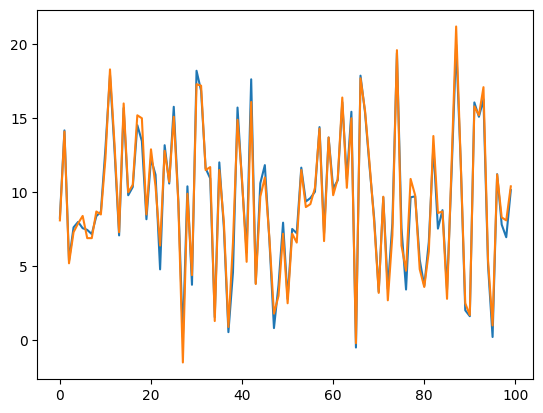

In [5]:
val_predictions = model.predict(x_test).flatten()
val_results = pd.DataFrame(data={'Predicted': val_predictions, "Actual": y_test.flatten()})

val_results['Predicted'] = val_results['Predicted'].apply(lambda x: x * train_std + train_mean)
val_results['Actual'] = val_results['Actual'].apply(lambda x: x * train_std + train_mean)

plt.plot(val_results['Predicted'][0:100])
plt.plot(val_results['Actual'][0:100])